In [22]:
import torch
import gc

gc.collect()

torch.cuda.empty_cache()

In [23]:
import os

# third-party library
import torch
import torch.nn as nn
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt



EPOCH = 7
BATCH_SIZE = 50
LR = 0.003
DOWNLOAD_MNIST = True
ROOT_PATH = './mldata/mnist/'

if not(os.path.exists(ROOT_PATH)) or not os.listdir(ROOT_PATH):
    DOWNLOAD_MNIST = True

device = "cuda" if torch.cuda.is_available() else "cpu"
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}

affine_transfomer = transforms.RandomAffine(degrees=(0, 0), translate=(0.3, 0.3), scale=(0.5, 0.75))
train_data = torchvision.datasets.MNIST(
    root=ROOT_PATH,
    train=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    affine_transfomer,
    ]),
    download=DOWNLOAD_MNIST,
)


train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, **kwargs,)

test_data = torchvision.datasets.MNIST(root=ROOT_PATH, train=False)
test_x = (torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:3000]/255.).to(device)
test_y = (test_data.test_labels[:3000]).to(device)



## Example of Data Augmentation

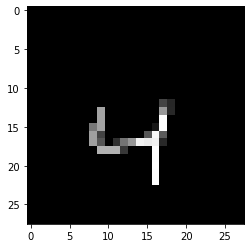

In [24]:
affine_transfomer = transforms.RandomAffine(degrees=(0, 0), translate=(0.3, 0.3), scale=(0.5, 0.75))
im = train_data.train_data[2].unsqueeze(0)
affine_imgs = [affine_transfomer(im) for _ in range(4)]
plt.imshow(affine_imgs[0].permute(1, 2, 0).numpy(), cmap='gray')

## Architecture

In [25]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), #0
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), #3
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), #6
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), #10
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
            )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),            
            nn.Dropout(0.5),

            nn.Linear(64, 10),
        )
        
    def forward(self, x):
        output = self.conv_block(x)
        output = output.view(output.size(0), -1)
        output = self.linear_block(output)
        
        return output, x


cnn = CNN().to(device)

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted


### Training (Change load_checkpoint if you want to train it by yourself)

In [26]:
load_checkpoint = True

if(load_checkpoint):
    cnn.load_state_dict(torch.load("./models/cnn_char_ckpt.pth"))
    cnn.eval()
else:
    from IPython.display import clear_output

    cnn.train()

    for epoch in range(EPOCH):
        for step, (b_x, b_y) in enumerate(train_loader):   
            output = cnn(b_x.to(device))[0]            
            loss = loss_func(output, b_y.to(device))   
            optimizer.zero_grad()           
            loss.backward()                 
            optimizer.step()                

    plt.ioff()
    torch.save(cnn.state_dict(), "./models/cnn_char_ckpt.pth")

### Test

In [27]:
# %matplotlib tk

import numpy as np
import torch
import torch.nn.functional as nnf
import cv2
 
drawing = False
pt1X , pt1Y = None , None
imgResult = np.zeros((512,512,1), np.uint8)
cnn.eval()
# print(cnn(test_x[0]))

def TestDraw(testImage):
    char = 0    
    output = cnn(testImage.to(device))[0]    
    prob = nnf.softmax(output, dim=1)
    top_p, top_class = prob.topk(1, dim = 1)   

    return top_class.item(), top_p.item() #class and score

def ClearDraw():    
    img[:,:,:] = 0    

# mouse callback
def line_drawing(event,x,y,flags,param):
    global pt1X,pt1Y,drawing

    if event==cv2.EVENT_LBUTTONDOWN:
        drawing=True
        pt1X,pt1Y=x,y

    elif event==cv2.EVENT_MOUSEMOVE:
        if drawing==True:
            cv2.line(img,(pt1X,pt1Y),(x,y),color=(255,255,255),thickness=25)
            pt1X,pt1Y=x,y

            # Resize and test agains the model      
            imgResized = cv2.resize(img, (28, 28),interpolation=cv2.INTER_NEAREST)
            
            # imgResized = cv2.GaussianBlur(imgResized,(3,3),cv2.BORDER_CONSTANT)
            imgResized = cv2.normalize(imgResized, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            # imgResized = cv2.normalize(dst, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            # _image = np.array(imgResized)
            # image = torch.from_numpy(_image)
            # image = image[np.newaxis, :] 
            imgTensor = torch.FloatTensor(imgResized)   
            imgTensor = imgTensor.unsqueeze(0)
            imgTensor = imgTensor.unsqueeze(0)
            top, confidence = TestDraw(imgTensor)            

            # Clear
            imgResult[:,:,:] = 0                
            text = "%d" % top
            cv2.putText(imgResult, text, (xText, yText), font, font_size, font_color, font_thickness, cv2.LINE_AA)                           
            text = "Confidence: %.2f" % confidence
            cv2.putText(imgResult, text, (xText, yText+30), font, font_size, font_color, font_thickness, cv2.LINE_AA)    
            cv2.imshow('Result',imgResult)
           
    elif event==cv2.EVENT_LBUTTONUP:
        drawing=False
        cv2.line(img,(pt1X,pt1Y),(x,y),color=(255,255,255),thickness=25)     

        imgResized = cv2.resize(img, (28, 28),interpolation=cv2.INTER_NEAREST)            
        # imgResized = cv2.GaussianBlur(imgResized,(1,1),cv2.BORDER_CONSTANT)
        imgResized = cv2.normalize(imgResized, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        # print(imgResized)
        # cv2.imwrite('./test0.png', imgResized)
        # cv2.imshow('Resized',cv2.resize(img, (28, 28),interpolation=cv2.INTER_CUBIC)) 


img = np.zeros((512,512,1), np.uint8)
cv2.namedWindow('Test Char')
cv2.resizeWindow('Test Char', 512, 512)
cv2.setMouseCallback('Test Char',line_drawing)

cv2.namedWindow('Result', cv2.WINDOW_KEEPRATIO)
cv2.resizeWindow('Result', 512, 512)

color = (255,255,255)
font = cv2.FONT_HERSHEY_SIMPLEX
font_size = 1
font_color = color
font_thickness = 2
xText,yText = 30,50    

while(1):
    k = cv2.waitKey(33)
    if(k == 27): # esc        
        break
    elif k == ord('c'):    
        ClearDraw()   
    cv2.imshow('Test Char',img)
 
cv2.destroyAllWindows()

### Filters

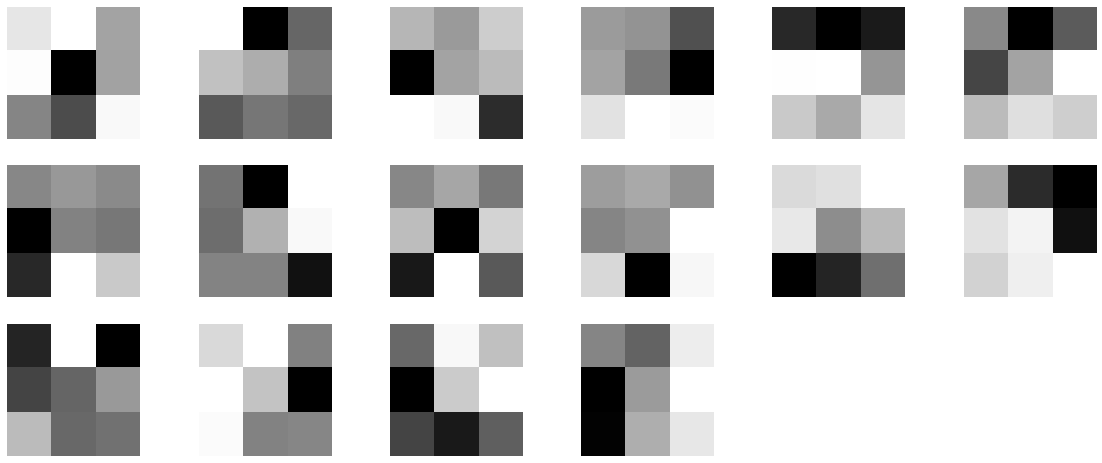

In [28]:
plt.figure(figsize=(20, 17))
for i, filter in enumerate(cnn.conv_block[0].weight.data):
    plt.subplot(6, 6, i+1)
    plt.imshow(filter[0, :, :].detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

### Activations from the first layer

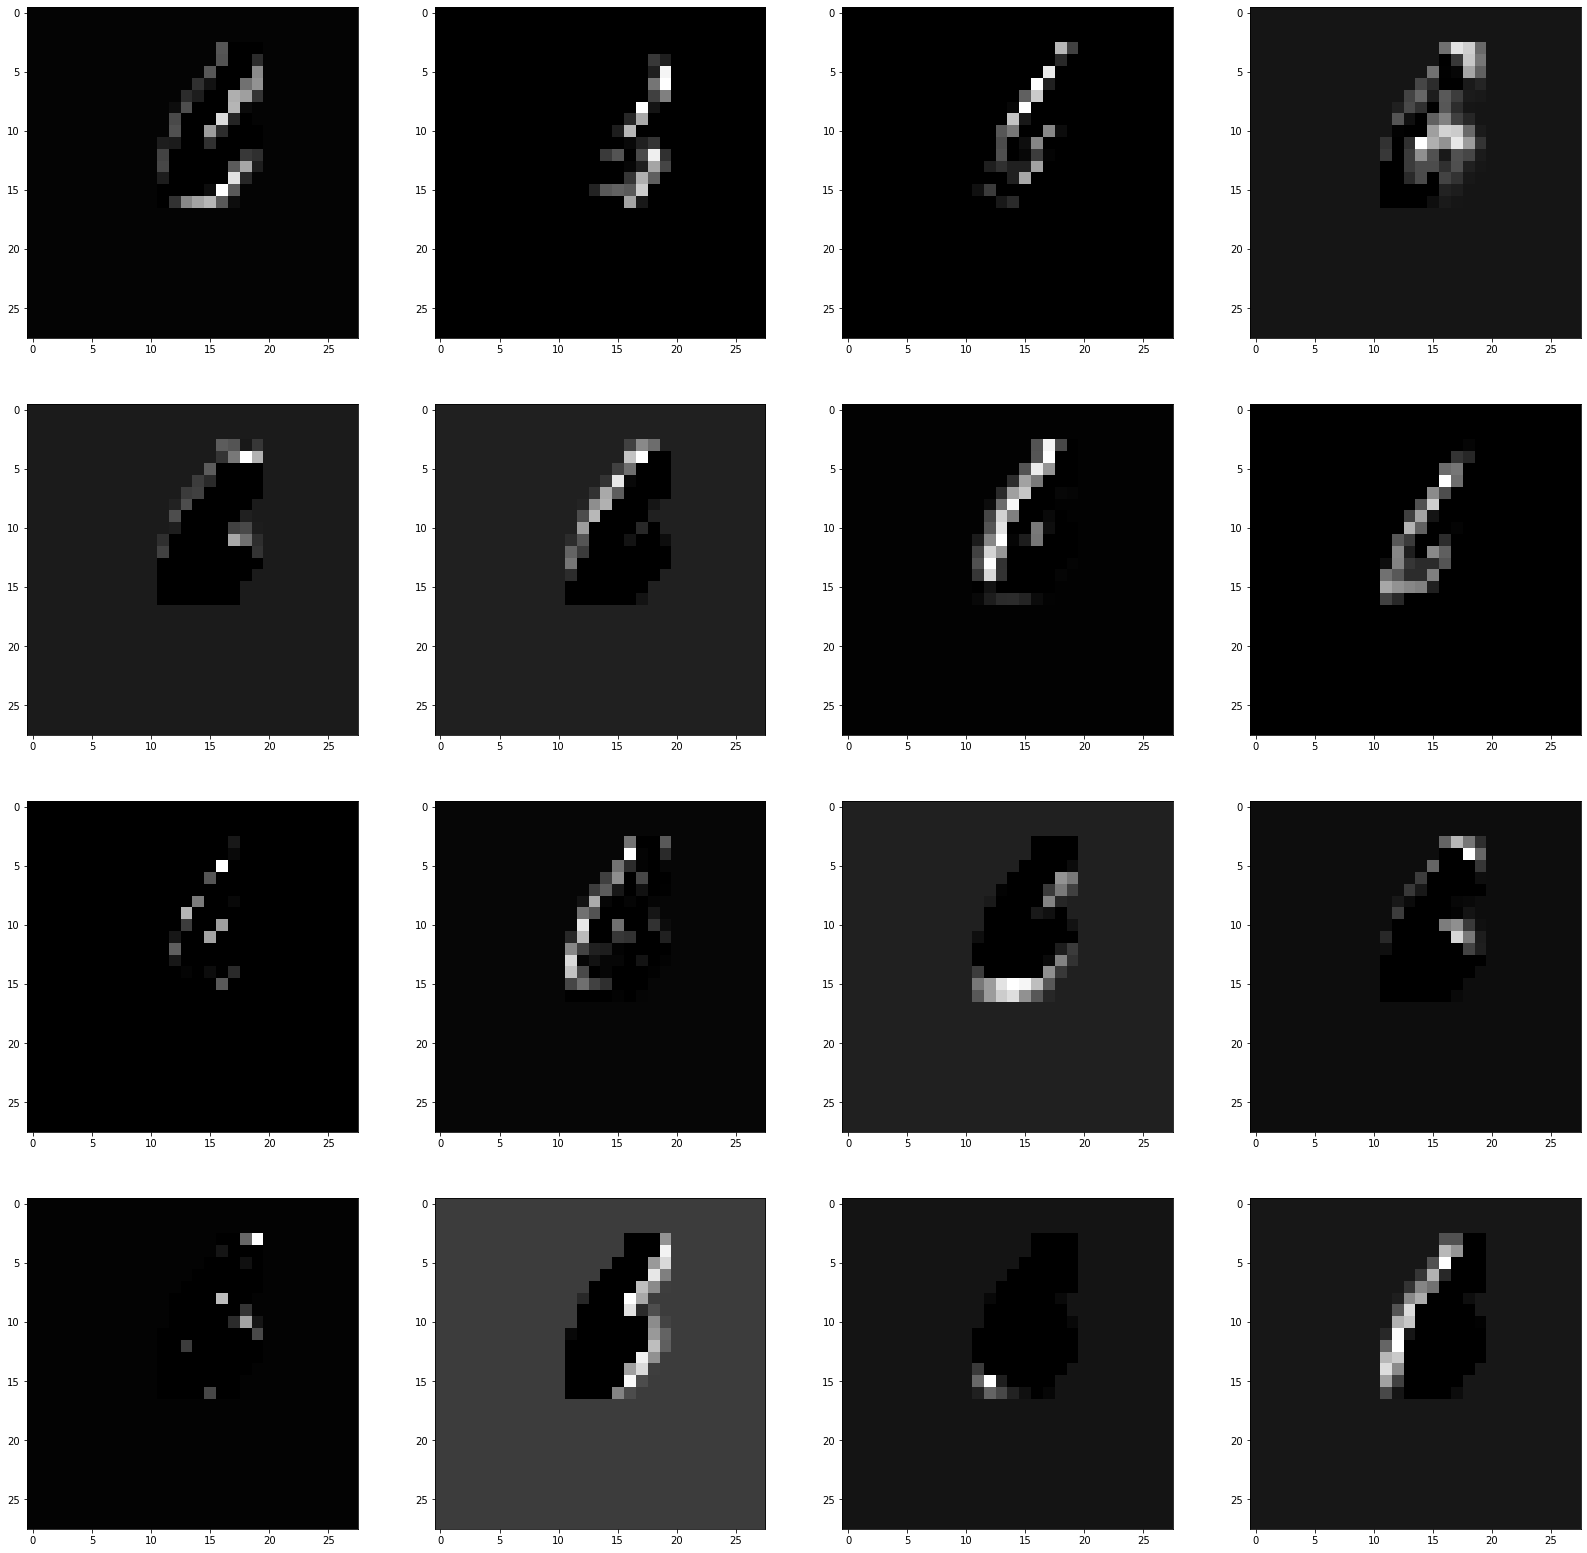

In [29]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


cnn.conv_block[2].register_forward_hook(get_activation('conv1'))
data = train_loader.dataset[9997][0]
data=data.to(device)
data.unsqueeze_(0)
output = cnn(data)

k=0
act = activation['conv1'].squeeze()
fig, axarr = plt.subplots(act.size(0)//4,4,figsize=(28, 28))

for i in range(act.size(0)//4):
        for j in range(4):
           axarr[i,j].imshow(act[k].detach().cpu().numpy(), cmap="gray")
           k+=1    

### Activations from the second layer

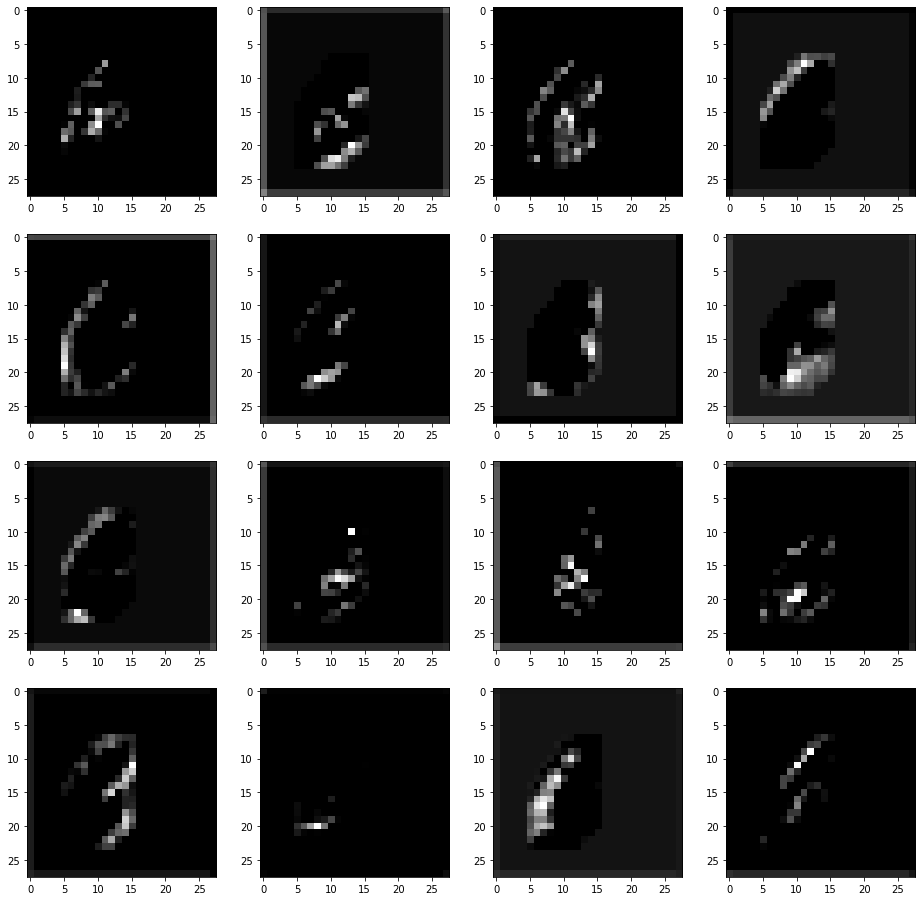

In [30]:
cnn.conv_block[5].register_forward_hook(get_activation('conv2'))
data =train_loader.dataset[9997][0]
data=data.to(device)
data.unsqueeze_(0)
output = cnn(data)
act = activation['conv2'].squeeze()

fig, axarr = plt.subplots(4,4,figsize=(16, 16))
k=0
for i in range(4):
        for j in range(4):
          axarr[i,j].imshow(act[k].detach().cpu().numpy(), cmap="gray")
          k+=1  